# Transporter analysis of bacillus mother-spore

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
with open("../../me_models/solution.pickle", "rb") as outfile:
    me = pickle.load(outfile)

### NDP and NTP transport

In [3]:
import sympy
import cobrame
import pickle
from cobrame.util.helper_functions import solve_me_model,flux_based_reactions
def gene_ko(model,genes):
    for g in genes:
        model.reactions.get_by_id('translation_{}'.format(g)).bounds = (0,0)
    return model

def load_spore_model(add_transport = False):
    with open("./sporeme_solution_v4_proteomics.pickle", "rb") as infile:
        model = pickle.load(infile)
    if add_transport:
        model = add_transport_to_model(model,add_transport)
    return model

def load_me_model():
    with open("/home/jt/UCSD/bacillusme-master/bacillusme/me_models/iJT964-ME.pickle", "rb") as infile:
        model = pickle.load(infile)
    return model

def get_response(model,growth_key='mu'):
    solve_me_model(model,
                   max_mu = 0.1,
                   min_mu = .01,
                   using_soplex=False,
                   precision = 1e-6,
                   growth_key = growth_key,
                   verbosity=0)
    if model.solution:
        return model.solution.x_dict#['biomass_dilution_s']
    else:
        return {r.id:0. for r in model.reactions}
    
def add_transport_to_model(model,met,cplx = 'CPLX_dummy'):
    rxn = cobrame.MEReaction('{}_FWD_transport'.format(met))
    model.add_reactions([rxn])
    rxn.add_metabolites({
        '{}_c'.format(met):-1,
        '{}_s'.format(met):1,
        cplx:sympy.Symbol('-1.0*sigma')
    })
    rxn.bounds = (0,1000)
    
    rxn = cobrame.MEReaction('{}_REV_transport'.format(met))
    model.add_reactions([rxn])
    rxn.add_metabolites({
        '{}_c'.format(met):1,
        '{}_s'.format(met):-1,
        cplx+'_s':sympy.Symbol('-1.0*sigma')
    })
    rxn.bounds = (0,1000)
#     print(rxn.metabolites)
    return model
    
def test_essentiality(genes,add_transport=False):
    d = {}
    # No deg
    print('No deg')
    model = load_spore_model()
    d['no_deg'] = get_response(model,growth_key='sigma')
    print(d['no_deg']['biomass_dilution_s'])
    
    # MC
    print('MC')
    model = load_spore_model(add_transport=add_transport)
    mc_genes = [i for i in genes]
    model = gene_ko(model,mc_genes)
    d['MC'] = get_response(model,growth_key='sigma')
    print(d['MC']['biomass_dilution_s'])
    
    # FS
    print('FS')
    model = load_spore_model(add_transport=add_transport)
    fs_genes = [i+'_s' for i in genes]
    model = gene_ko(model,fs_genes)
    d['FS'] = get_response(model,growth_key='sigma')
    print(d['FS']['biomass_dilution_s'])
    
    # Both
    print('Both')
    model = load_spore_model(add_transport=add_transport)
    both_genes = mc_genes + fs_genes
    model = gene_ko(model,both_genes)
    d['both'] = get_response(model,growth_key='sigma')
    print(d['both']['biomass_dilution_s'])
    
    # Germination
    print('Germination')
    model = load_me_model() 
    model = gene_ko(model,genes)
    d['germination'] = get_response(model,growth_key='mu')
    print(d['germination']['biomass_dilution'])
    return d

In [234]:
flux_based_reactions(sporeme,'glx_c')

No reactions found for dhor_c


In [68]:
results = {}

In [ ]:
results['gmk'] = {}
results['gmk']['no_transport'] = test_essentiality(['BSU15680']) # gmk
results['gmk']['gdp_transport'] = test_essentiality(['BSU15680'],add_transport = 'gdp') # gmk
results['gmk']['gtp_tr ansport'] = test_essentiality(['BSU15680'],add_transport = 'gtp') # gmk

No deg
0.06048812866210937
MC


In [ ]:
results['cmk_pyrG'] = {}
results['cmk_pyrG']['no_transport'] = test_essentiality(['BSU22890','BSU37150']) # cmk + pyrG
results['cmk_pyrG']['cdp_transport'] = test_essentiality(['BSU22890','BSU37150'],add_transport = 'cdp')
results['cmk_pyrG']['ctp_transport'] = test_essentiality(['BSU22890','BSU37150'],add_transport = 'ctp')

In [98]:
with open("transport_results_high.pickle", "wb") as outfile:
    pickle.dump(results,outfile)

In [99]:
with open("./transport_results_high.pickle", "rb") as f:
    results = pickle.load(f)

In [46]:
import pandas as pd

In [4]:
sporeme = load_spore_model()

In [43]:
flux_dict = results['gmk']['gdp_transport']['FS']
# df = flux_based_reactions(sporeme,'gdp_s',flux_dict=flux_dict)
flux_dict['gdp_FWD_transport'],flux_dict['gdp_REV_transport']

(0.008292884832785806, 0.0)

In [44]:
flux_dict = results['gmk']['gdp_transport']['MC']
# df = flux_based_reactions(sporeme,'gdp_s',flux_dict=flux_dict)
flux_dict['gdp_FWD_transport'],flux_dict['gdp_REV_transport']

(0.0, 0.00783290404466194)

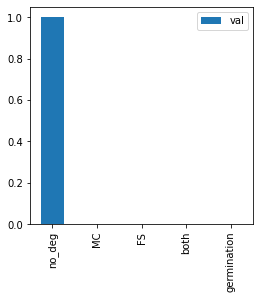

In [102]:
condition = 'no_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}.svg'.format(gene,condition),format='SVG')

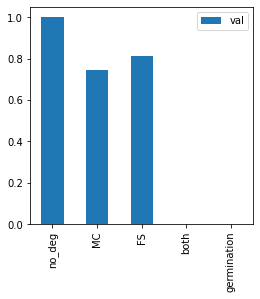

In [103]:
condition = 'gdp_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}.svg'.format(gene,condition),format='SVG')

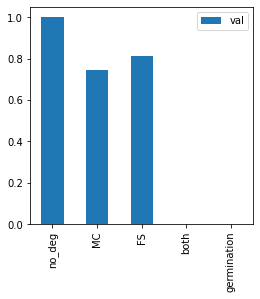

In [104]:
condition = 'gtp_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}.svg'.format(gene,condition),format='SVG')

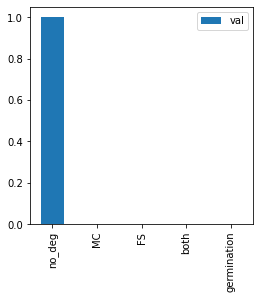

In [105]:
condition = 'no_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}.svg'.format(gene,condition),format='SVG')

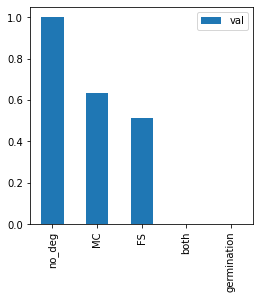

In [106]:
condition = 'cdp_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}.svg'.format(gene,condition),format='SVG')

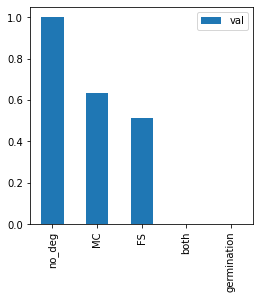

In [107]:
condition = 'ctp_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_{}_{}.svg'.format(gene,condition),format='SVG')

### NDK

In [ ]:
d = test_essentiality(['BSU15680'])
print(d)

In [ ]:
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in d.items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_ndk.svg'.format(gene,condition),format='SVG')

### Is CS essential for growth? (citZ)

In [3]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [15]:
me.reactions.get_by_id('CS_FWD_BSU29140-MONOMER').upper_bound=0

In [16]:
me.reactions.get_by_id('CS_FWD_BSU09440-MONOMER').upper_bound=0

In [17]:
solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 206.843772 seconds
Finished substituting S,lb,ub in 9.316815 seconds
Finished makeME_LP in 1.050280 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 8.988180 seconds
Finished makeME_LP in 1.024608 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 8.833023 seconds
Finished makeME_LP in 1.023247 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.125 0.0625 optimal
Finished substituting S,lb,ub in 8.823088 seconds
Finished makeME_LP in 1.033025 seconds
Getting MINOS parameters from ME_NLP...
4 0.0625 0.0625 0.09375 0.09375 1
Finished substituting S,lb,ub in 8.736071 seconds
Finished makeME_LP in 1.016968 seconds
Getting MINOS parameters from ME_NLP...
5 0.078125 0.078125 0.09375 0.078125 optimal
Finished substituting S,lb,ub in 8.684958 seconds
Finished makeME_LP in 1.020726 seconds
Getti

In [ ]:
flux_dict = me.get_metabolic_flux()
pd.DataFrame.from_dict({'flux':flux_dict})#.to_csv('../fluxdist_CS-.csv')

### Closing mechanisms

In [3]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [4]:
sporeme.solution.x_dict['biomass_dilution_s']

0.06048797607421875

In [5]:
main_mechanisms = ['ACKr_REV_BSU29470-MONOMER',
                    'PGK_REV_BSU33930-MONOMER',
                    'PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k']

In [6]:
for r in main_mechanisms:
    sporeme.reactions.get_by_id(r).bounds = (0,0)
    sporeme.reactions.get_by_id(r+'_s').bounds = (0,0)

In [8]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-3,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 271.856053 seconds
Finished substituting S,lb,ub in 8.378582 seconds
Finished makeME_LP in 1.616164 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 8.380331 seconds
Finished makeME_LP in 1.781484 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.025 0.025 1
Finished substituting S,lb,ub in 8.137363 seconds
Finished makeME_LP in 1.595356 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.0125 0.0125 1
Finished substituting S,lb,ub in 7.924966 seconds
Finished makeME_LP in 1.464949 seconds
Getting MINOS parameters from ME_NLP...
4 0.00625 0.00625 0.0125 0.00625 optimal
Finished substituting S,lb,ub in 7.407033 seconds
Finished makeME_LP in 1.441859 seconds
Getting MINOS parameters from ME_NLP...
5 0.009375000000000001 0.009375000000000001 0.0125 0.009375000000000001 optimal
Finished substituting S,lb,ub in 7.140407 seconds
Finished make

In [9]:
sporeme.solution.x_dict['biomass_dilution_s']

0.010156250000000002

In [ ]:
sporeme.reactions.get_by_id('PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s').bounds = (0,0)
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-3,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 255.152021 seconds
Finished substituting S,lb,ub in 7.613632 seconds
Finished makeME_LP in 1.692763 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 7.519974 seconds
Finished makeME_LP in 1.441841 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.025 0.025 1
Finished substituting S,lb,ub in 7.493055 seconds
Finished makeME_LP in 1.434940 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.0125 0.0125 1
Finished substituting S,lb,ub in 7.452662 seconds


In [12]:
if sporeme.solution: sporeme.solution.x_dict['biomass_dilution_s']

### Energy mechanisms

In [115]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [116]:
# main_mechanisms = [ 'ACKr_REV_BSU29470-MONOMER_s',
#                     'PGK_REV_BSU33930-MONOMER_s',
#                     'PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s',
#                     'PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s']

In [110]:
# for r in main_mechanisms:
#     sporeme.reactions.get_by_id(r).bounds = (0,0)

In [117]:
# solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

In [118]:
if sporeme.solution: print(sporeme.solution)

<Solution 0.02 at 0x7f4963296240>


In [120]:
df = flux_based_reactions(sporeme,'atp_s',only_types=['MetabolicReaction'])

In [127]:
prod_df = df[df['met_flux']>0]['met_flux']
prod_df.div(prod_df.sum())

ACKr_REV_BSU29470-MONOMER_s                        0.871869
PGK_REV_BSU33930-MONOMER_s                        0.0598518
PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s          0.0467248
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s       0.0138753
ADK1_REV_BSU01370-MONOMER_mod_mg2_s              0.00756392
URIDK2r_copy2_REV_BSU00280-MONOMER_mod_mg2_s    0.000115594
LAAL11_FWD_BSU37710-MONOMER_s                   9.30605e-34
LAAL10_FWD_BSU37710-MONOMER_s                   6.17895e-34
LAAL39_FWD_BSU37710-MONOMER_s                   5.42867e-34
LAAL29_FWD_BSU37710-MONOMER_s                   3.11326e-34
LAAL9_FWD_BSU37710-MONOMER_s                    1.76714e-34
LAAL23_FWD_BSU37710-MONOMER_s                   1.33991e-34
GTPDPK_FWD_BSU27600-MONOMER_mod_mn2_s           3.38839e-36
Name: met_flux, dtype: object

# Amino acids

In [221]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [225]:
pd.DataFrame.from_dict({'flux':sporeme.solution.x_dict}).to_csv('Supplementary File 2.csv')

In [50]:
# for r in get_transport_reactions(sporeme,'met__L_s',comps=['c','s']):
#     print(r.id)
#     r.bounds = (0,0)

METabc_FWD_CPLX8J2-67_s


In [ ]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-3,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 262.401473 seconds
Finished substituting S,lb,ub in 7.640560 seconds
Finished makeME_LP in 1.458240 seconds
Getting MINOS parameters from ME_NLP...
1 0.05 0.05 0.1 0.05 optimal
Finished substituting S,lb,ub in 7.455499 seconds
Finished makeME_LP in 1.442462 seconds
Getting MINOS parameters from ME_NLP...
2 0.05 0.05 0.07500000000000001 0.07500000000000001 1
Finished substituting S,lb,ub in 7.369377 seconds
Finished makeME_LP in 1.439852 seconds
Getting MINOS parameters from ME_NLP...
3 0.05 0.05 0.0625 0.0625 1


In [142]:
if sporeme.solution: print(sporeme.solution.x_dict['biomass_dilution_s'])

0.06048797607421875


In [179]:
for m in sporeme.metabolites.query(re.compile('^[a-z]{3}__L_s|^gly_c$')):
    df = flux_based_reactions(sporeme,m.id,only_types=['MetabolicReaction'])
    prod = df[df['met_flux']>0]['met_flux']
    prod = prod.div(prod.sum())
    top = df.sort_values('met_flux').iloc[[-1]]
    print(m)
    if top['met_flux'][0] > 0:
        print(top['reaction'][0])
        print(top['met_flux'][0])
        print('{} %'.format(str(prod.loc[top.index[0]]*100)))
    else:
        print('No production')
    print('\n')

gly_c
ser__L_c + thf_c --> -1.13628819200723e-5*sigma BSU36900-MONOMER + gly_c + h2o_c + mlthf_c
0.03878370026938251
100.0 %


met__L_s
5mthf_s + hcys__L_s --> -6.99881286711861e-6*sigma BSU13180-MONOMER_mod_zn2_s + h_s + met__L_s + thf_s
0.00357686949617453
100.0 %


trp__L_s
h_c + trp__L_c --> -0.000162200908237131*sigma BSU10010-MONOMER_s + h_s + trp__L_s
0.001251207163095963
100.0 %


glu__L_s
akg_s + pser__L_s --> 3php_s + -7.40403384347267e-6*sigma BSU10020-MONOMER_mod_pydx5p_s + glu__L_s
0.07624531029838442
86.71339611174787 %


ser__L_s
h2o_s + pser__L_s --> -1.94943050983268e-5*sigma BSU04740-MONOMER_s + pi_s + ser__L_s
0.019284705696617877
100.0 %


lys__L_s
h_s + lys__L_c --> -0.000131840779608342*sigma BSU10870-MONOMER_s + h_c + lys__L_s
0.007396340179854296
100.0 %


phe__L_s
glu__L_s + phpyr_s --> -4.27350427350427e-6*sigma BSU34890-MONOMER_s + akg_s + phe__L_s
0.015741796029360294
100.0 %


leu__L_s
h_c + leu__L_c --> -4.27350427350427e-6*sigma BSU29600-MONOMER_s + h_s +

In [202]:
for m in sporeme.metabolites.query(re.compile('^[guca][m]p_s$')):
    df = flux_based_reactions(sporeme,m.id,only_types=['MetabolicReaction'])
    prod = df[df['met_flux']>0]['met_flux']
    prod = prod.div(prod.sum())
    top = df.sort_values('met_flux').iloc[[-1]]
    print(m)
    if top['met_flux'][0] > 0:
        print(top['reaction'][0])
        print(top['met_flux'][0])
        print('{} %'.format(str(prod.loc[top.index[0]]*100)))
    else:
        print('No production')
    print('\n')

ump_s
30.0 h2o_s + 30.0 uacgala_s + 30.0 udpg_s --> -4.27350427350427e-6*sigma CPLX000-68_s + 60.0 h_s + tcam_BS_s + 30.0 udp_s + 30.0 ump_s
0.04672750624226834
79.88297393204063 %


amp_s
2.0 adp_s --> -4.27350427350427e-6*sigma BSU01370-MONOMER_mod_mg2_s + amp_s + atp_s
0.18912173697575754
84.37705362909459 %


cmp_s
45.0 cdpglyc_s + uacgam_s + uacmam_s --> -4.27350427350427e-6*sigma CPLX000-65_s + 45.0 cmp_s + gtca1_45_BS_s + 46.0 h_s + udp_s + ump_s
0.009864379138183593
22.19677566828181 %


gmp_s
gmp_c + h_c --> -4.27350427350427e-6*sigma CPLX_dummy_s + gmp_s + h_s
0.34887197559954297
100.0 %




In [219]:
for r in sporeme.metabolites.get_by_id('BSU37150-MONOMER_mod_mg2').reactions:
    print(r.id)
    print(r.reaction)

CTPS1_FWD_BSU37150-MONOMER_mod_mg2
atp_c + nh4_c + utp_c --> -4.27350427350427e-6*sigma BSU37150-MONOMER_mod_mg2 + adp_c + ctp_c + 2.0 h_c + pi_c
CTPS2_FWD_BSU37150-MONOMER_mod_mg2
atp_c + gln__L_c + h2o_c + utp_c --> -3.27559071090038e-6*sigma BSU37150-MONOMER_mod_mg2 + adp_c + ctp_c + glu__L_c + 2.0 h_c + pi_c
formation_BSU37150-MONOMER_mod_mg2
mg2_c + 4.0 protein_BSU37150 --> BSU37150-MONOMER_mod_mg2 + 0.04861 prosthetic_group_biomass


In [220]:
flux_based_reactions(sporeme,'ctp_s',only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
NDPK3_FWD_BSU22730-MONOMER_mod_mn2_s,0,999999,0.0455577,0.0455577,atp_s + cdp_s --> -4.27350427350427e-6*sigma BSU22730-MONOMER_mod_mn2_s + adp_s + ctp_s
G3PCT_FWD_BSU35740-MONOMER_s,0,999999,0.0318895,-0.0318895,ctp_s + glyc3p_s + h_s --> -4.27350427350427e-6*sigma BSU35740-MONOMER_s + cdpglyc_s + ppi_s
PHCYT_BS_FWD_BSU16540-MONOMER_mod_mg2_mod_k_s,0,999999,0.00699652,-0.00699652,0.01 12dag3p_BS_s + ctp_s + h_s --> -1.54262689436083e-5*sigma BSU16540-MONOMER_mod_mg2_mod_k_s + 0.01 cdpdag_BS_s + ppi_s
MEPCT_FWD_BSU00900-MONOMER_mod_mn2_s,0,999999,0.000112629,-0.000112629,2me4p_s + ctp_s + h_s --> 4c2me_s + -1.03246272317615e-5*sigma BSU00900-MONOMER_mod_mn2_s + ppi_s
NDPK3_REV_BSU22730-MONOMER_mod_mn2_s,0,999999,0,-0,adp_s + ctp_s --> -4.27350427350427e-6*sigma BSU22730-MONOMER_mod_mn2_s + atp_s + cdp_s
BIOMASS_BS_10_FWD_CPLX_dummy_s,0,0,0,-0,0.000367 10fthf_s + 0.266902 ala__L_s + 0.00467 amp_s + 0.193021 arg__L_s + 0.147987 asn__L_s + 0.148014 asp__L_s + 105.053483 atp_s + 0.003205 ca2_s + 5e-06 cdlp_BS_s + 0.000251 cdp_s + 0.001042 cmp_s + 0.038902 ctp_s + 0.05699 cys__L_s + 0.00011 d12dg_BS_s + 0.022982 datp_s + 0.01738 dctp_s + 0.017398 dgtp_s + 0.022899 dttp_s + 0.00345 fe3_s + 0.00018 gdp_s + 0.260335 gln__L_s + 0.260378 glu__L_s + 0.408288 gly_s + 0.000503 gmp_s + 0.003624 gtca1_45_BS_s + 0.002347 gtca2_45_BS_s + 0.001819 gtca3_45_BS_s + 0.062667 gtp_s + 105.0 h2o_s + 0.081739 his__L_s + 0.269905 ile__L_s + 0.706312 k_s + 0.346445 leu__L_s + 7e-06 lipo1_24_BS_s + 6e-06 lipo2_24_BS_s + 1.8e-05 lipo3_24_BS_s + 1.5e-05 lipo4_24_BS_s + 0.323093 lys__L_s + 2.2e-05 lysylpgly_BS_s + 8.6e-05 m12dg_BS_s + 0.113326 met__L_s + 0.101714 mg2_s + 0.000266 mql7_s + 0.016164 nad_s + 0.000934 nadp_s + 0.000216 nadph_s + 0.101817 peptido_BS_s + 0.000176 pgly_BS_s + 0.175939 phe__L_s + 0.000918 ppi_s + 0.160642 pro__L_s + 0.00056 psetha_BS_s + 0.216213 ser__L_s + 6.6e-05 t12dg_BS_s + 0.003112 tcam_BS_s + 0.186317 thr__L_s + 0.054336 trp__L_s + 0.110824 tyr__L_s + 0.041501 utp_s + 0.306734 val__L_s --> -4.27350427350427e-6*sigma CPLX_dummy_s + 104.997414 adp_s + 105.0 h_s + 104.985613 pi_s
G3PCT_FWD_CPLX-5322_s,0,999999,0,-0,ctp_s + glyc3p_s + h_s --> -0.000185492911781972*sigma CPLX-5322_s + cdpglyc_s + ppi_s
CTPS1_FWD_BSU37150-MONOMER_mod_mg2_s,0,999999,0,0,atp_s + nh4_s + utp_s --> -4.27350427350427e-6*sigma BSU37150-MONOMER_mod_mg2_s + adp_s + ctp_s + 2.0 h_s + pi_s
CTPS2_FWD_BSU37150-MONOMER_mod_mg2_s,0,999999,0,0,atp_s + gln__L_s + h2o_s + utp_s --> -3.27559071090038e-6*sigma BSU37150-MONOMER_mod_mg2_s + adp_s + ctp_s + glu__L_s + 2.0 h_s + pi_s
PPNCL_FWD_BSU15700-MONOMER_s,0,999999,0,-0,4ppan_s + ctp_s + cys__L_s --> 4ppcys_s + -3.22695132810028e-6*sigma BSU15700-MONOMER_s + cdp_s + h_s + pi_s


# With NTP transport

In [203]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [204]:
def add_transport(model,mets):
    for i in mets:
        rxn = cobrame.MEReaction('{}_transport'.format(i))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(i):-1,
            '{}_s'.format(i):1
        })
        rxn.bounds = (-1000,1000)

In [205]:
add_transport(sporeme,['atp','gtp','ctp','utp'])

In [206]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-3,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 279.953369 seconds
Finished substituting S,lb,ub in 9.010928 seconds
Finished makeME_LP in 1.584175 seconds
Getting MINOS parameters from ME_NLP...


KeyboardInterrupt: 

# Characterizing transport

In [ ]:
version = 'v4_proteomics'

In [55]:
with open("./sporeme_solution_{}.pickle".format(version), "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [ ]:
# Get transport reactions

def get_compartments(r):
    comps = []
    if isinstance(r,cobrame.MetabolicReaction):
        for m in r.metabolites:
            if isinstance(m,cobrame.Metabolite):
                comps.append(m.id[-1])
    return list(set(comps))

def get_all_transport(model):
    transport_reactions = []
    for r in tqdm(model.reactions):
        comps = get_compartments(r)
        if len(comps) > 1 and 's' in comps:
            transport_reactions.append(r.id)
    return list(set(transport_reactions))

def get_active_transport(transport_reactions):
    active_transporters = []
    for r in tqdm(transport_reactions):
        if 'SPONT' not in r and abs(sporeme.solution.x_dict[r])>0.:
            active_transporters.append(r)
    # Include arginine transport
    arginine_transport = [r.id for r in get_transport_reactions(sporeme,'arg__L_c',comps=['c','s'])+get_transport_reactions(sporeme,'arg__L_c',comps=['s','c'])]
    [active_transporters.append(r) for r in arginine_transport]
    active_transporters = list(set(active_transporters))
    return active_transporters

## Check by group of transporters of metabolite

In [ ]:
def get_necessary_metabolites(model,active_transporters):
    necessary_metabolites = []
    for r in tqdm(active_transporters):
        rxn = model.reactions.get_by_id(r)
        for m in rxn.products:
            if not isinstance(m,cobrame.Metabolite):
                continue
            met_root = m.id[:-2]
            for i in rxn.reactants:
                if met_root in i.id:
                    necessary_metabolites.append(m.id)
    return list(set(necessary_metabolites))

def get_all_available_transport(model,necessary_metabolites):
    available_transport = []
    at_dict = {}
    for m in tqdm(necessary_metabolites):
        rxns = get_transport_reactions(model,m,comps=['c','s']) + get_transport_reactions(model,m,comps=['s','c'])
        [available_transport.append(r.id) for r in rxns]
        at_dict[m] = []
        [at_dict[m].append(r.id) for r in rxns]
    return list(set(available_transport)), at_dict

In [ ]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [ ]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))

In [ ]:
active_transporters = get_active_transport(transport_reactions)
necessary_metabolites = get_necessary_metabolites(sporeme,active_transporters)
necessary_metabolites.remove('h_s')
necessary_metabolites.remove('h_c')
available_transport, at_dict = get_all_available_transport(sporeme,necessary_metabolites)

In [ ]:
print('{} active transport reactions identified'.format(len(active_transporters)))
print('{} necessary metabolites identified'.format(len(necessary_metabolites)))
print('{} available transport reactions identified'.format(len(available_transport)))

In [ ]:
all_transporters_to_open = list(set(active_transporters + available_transport))
print('{} open transport reactions identified'.format(len(all_transporters_to_open)))
print('Included {}'.format(set(active_transporters)-set(available_transport)))

In [ ]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,necessary_metabolites, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')

In [ ]:
flux_results_df.to_csv('group_KO_flux_results_{}.csv'.format(version))

In [ ]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))
plt.tight_layout()
plt.savefig("./figures/group_KO_flux_results_{}.svg".format(version), format="SVG")

### Close metabolite one by one
Including information about arginine being transported

In [ ]:
with open("./sporeme_solution_{}.pickle".format(version), "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=False).drop('base').index.to_list()

In [ ]:
sorted_mets.remove('arg__L_s')
sorted_mets.append('arg__L_s')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,sorted_mets, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout',sequential=True)
flux_results_df.to_csv('group_1by1_KO_flux_results_{}.csv'.format(version))

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()
plt.savefig("./figures/group_1by1_KO_flux_results_{}.svg".format(version), format="SVG")

# Cases

In [ ]:
pd.set_option('display.max_colwidth', None)

### Original

In [128]:
# CYTK2 KO
version = 'v4'

<AxesSubplot:>

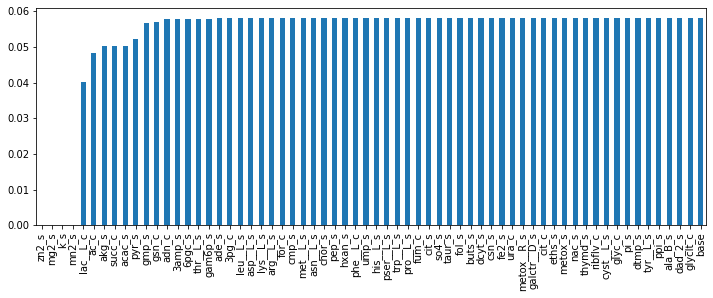

In [135]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))

In [136]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True)
last_met = sorted_mets.index[list(sorted_mets.index).index(sorted_mets[sorted_mets<1e-5].index[-1])+1]
print(last_met)
flux_dict = flux_results_df[last_met].to_dict() # Last time before model breaks

asn__L_s


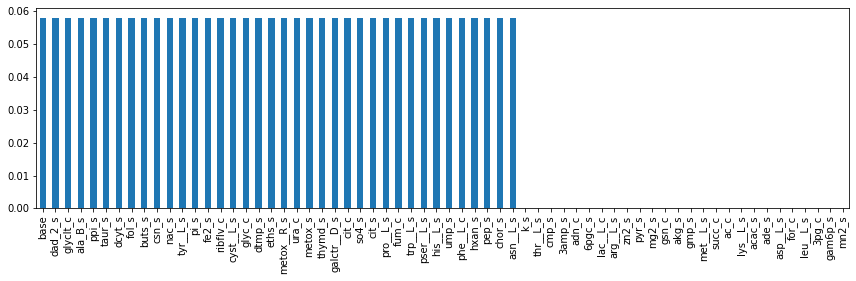

In [137]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets.index[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()

In [132]:
flux_dict['biomass_dilution']

0.02168148122087299

In [133]:
met='atp_s' # ATP production and glucose uptake
prod_atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])
prod_atp_df = prod_atp_df[prod_atp_df['met_flux']>0]
prod_atp_df['met_flux'].sum()

15.866048221386526

In [134]:
prod_atp_df['met_flux'].div(prod_atp_df['met_flux'].sum())

ACKr_REV_BSU29470-MONOMER_s                        0.435925
PGK_REV_BSU33930-MONOMER_s                         0.303972
PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s           0.222772
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s        0.021681
ADK1_REV_BSU01370-MONOMER_mod_mg2_s               0.0152716
ARGSS_REV_BSU29450-MONOMER_mod_mg2_s            0.000229173
URIDK2r_copy2_REV_BSU00280-MONOMER_mod_mg2_s    0.000118324
CYTK2_REV_BSU22890-MONOMER_mod_mg2_s            3.04227e-05
SUCOAS_FWD_CPLX8J2-7_s                          4.18044e-39
LAAL29_FWD_BSU37710-MONOMER_s                   9.05477e-40
PRASCSi_REV_BSU06450-MONOMER_s                   3.6099e-40
ARGKr_REV_CPLX_dummy_s                          1.41334e-40
LAAL23_FWD_BSU37710-MONOMER_s                   1.35944e-40
Name: met_flux, dtype: object

### All mechanisms KO

<AxesSubplot:>

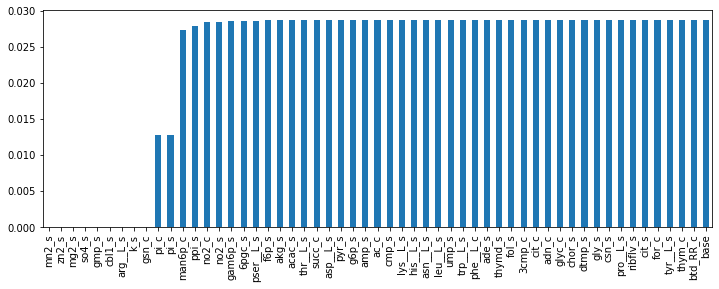

In [139]:
version = 'v5_all_KO'
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))

In [107]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True)
last_met = sorted_mets.index[list(sorted_mets.index).index(sorted_mets[sorted_mets<1e-5].index[-1])+1]
print(last_met)
flux_dict = flux_results_df[last_met].to_dict() # Last time before model breaks

thr__L_s


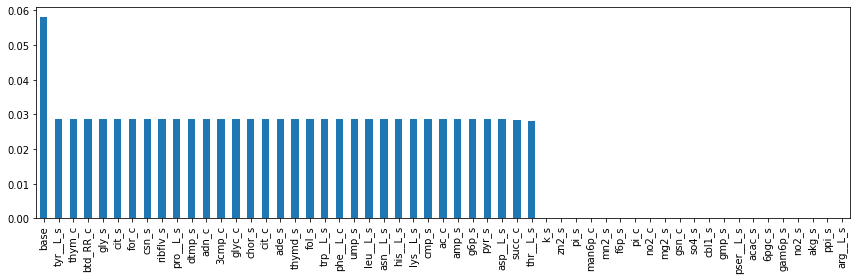

In [108]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets.index[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()

In [110]:
flux_dict['biomass_dilution']

0.011462839961196077

In [111]:
met='atp_s' # ATP production and glucose uptake
prod_atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])
prod_atp_df = prod_atp_df[prod_atp_df['met_flux']>0]
prod_atp_df['met_flux'].sum()

24.56360422878673

In [112]:
prod_atp_df['met_flux'].div(prod_atp_df['met_flux'].sum())

PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s        0.500522
ADK1_REV_BSU01370-MONOMER_mod_mg2_s                0.499333
ARGSS_REV_BSU29450-MONOMER_mod_mg2_s            9.02715e-05
URIDK2r_copy2_REV_BSU00280-MONOMER_mod_mg2_s    5.46958e-05
Name: met_flux, dtype: object

In [114]:
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s,0,999999,12.2946,12.2946,amp_s + h_s + prpp_s --> -1.38401264312306e-5*sigma BSU00510-MONOMER_mod_mn2_mod_pi_s + atp_s + r5p_s
ADK1_REV_BSU01370-MONOMER_mod_mg2_s,0,999999,12.2654,12.2654,2.0 adp_s --> -4.27350427350427e-6*sigma BSU01370-MONOMER_mod_mg2_s + amp_s + atp_s
PPIabc_FWD_CPLX_dummy_s,0,999999,12.1354,-12.1354,atp_s + h2o_s + ppi_c --> -4.27350427350427e-6*sigma CPLX_dummy_s + adp_s + h_s + pi_s + ppi_s
ACKr_FWD_BSU29470-MONOMER_s,0,999999,0.0737005,-0.0737005,ac_s + atp_s --> -4.27350427350427e-6*sigma BSU29470-MONOMER_s + actp_s + adp_s
NDPK2_FWD_BSU22730-MONOMER_mod_mn2_s,0,999999,0.0675318,-0.0675318,atp_s + udp_s --> -4.27350427350427e-6*sigma BSU22730-MONOMER_mod_mn2_s + adp_s + utp_s
...,...,...,...,...,...
ACKr_REV_BSU29470-MONOMER_s,0,0,0,0,actp_s + adp_s --> -4.27350427350427e-6*sigma BSU29470-MONOMER_s + ac_s + atp_s
FACOAL150_anteiso_REV_BSU18250-MONOMER_s,0,999999,0,0,amp_s + fa4coa_s + ppi_s --> -4.27350427350427e-6*sigma BSU18250-MONOMER_s + atp_s + coa_s + fa4_s
FACOAL150_anteiso_FWD_BSU18250-MONOMER_s,0,999999,0,-0,atp_s + coa_s + fa4_s --> -4.27350427350427e-6*sigma BSU18250-MONOMER_s + amp_s + fa4coa_s + ppi_s
FACOAL160_REV_BSU28560-MONOMER_mod_mg2_s,0,999999,0,0,amp_s + pmtcoa_s + ppi_s --> -4.27350427350427e-6*sigma BSU28560-MONOMER_mod_mg2_s + atp_s + coa_s + hdca_s


In [115]:
flux_based_reactions(sporeme,'prpp_s',flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
GUAPRT_REV_BSU00680-MONOMER_s,0,999999,12.2991,12.2991,gmp_s + ppi_s --> -4.27350427350427e-6*sigma BSU00680-MONOMER_s + gua_s + prpp_s
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s,0,999999,12.2946,-12.2946,amp_s + h_s + prpp_s --> -1.38401264312306e-5*sigma BSU00510-MONOMER_mod_mn2_mod_pi_s + atp_s + r5p_s
ORPT_REV_BSU15560-MONOMER_s,0,999999,0.00404941,-0.00404941,orot_s + prpp_s --> -1.86331330653874e-5*sigma BSU15560-MONOMER_s + orot5p_s + ppi_s
ATPPRT_FWD_BSU34920-MONOMER_s,0,999999,0.000298377,-0.000298377,atp_s + prpp_s --> -4.27350427350427e-6*sigma BSU34920-MONOMER_s + ppi_s + prbatp_s
ANPRT_FWD_BSU22670-MONOMER_s,0,999999,0.00012065,-0.00012065,anth_s + prpp_s --> -1.35361847172882e-5*sigma BSU22670-MONOMER_s + ppi_s + pran_s
NNDPR_FWD_BSU27860-MONOMER_mod_mg2_s,0,999999,5.98408e-10,-5.98408e-10,2.0 h_s + prpp_s + quln_s --> -2.4712036904137e-6*sigma BSU27860-MONOMER_mod_mg2_s + co2_s + nicrnt_s + ppi_s
PRPPS_FWD_BSU00510-MONOMER_mod_mn2_mod_pi_s,0,999999,0,0,atp_s + r5p_s --> -1.38401264312306e-5*sigma BSU00510-MONOMER_mod_mn2_mod_pi_s + amp_s + h_s + prpp_s
ADPT_FWD_BSU27610-MONOMER_mod_mg2_s,0,999999,0,-0,ade_s + prpp_s --> -1.30688922594939e-5*sigma BSU27610-MONOMER_mod_mg2_s + amp_s + ppi_s
NAPRT_REV_BSU31750-MONOMER_s,0,999999,0,0,nicrnt_s + ppi_s --> -2.68603911285977e-6*sigma BSU31750-MONOMER_s + h_s + nac_s + prpp_s
ATPPRT_REV_BSU34920-MONOMER_s,0,999999,0,0,ppi_s + prbatp_s --> -4.27350427350427e-6*sigma BSU34920-MONOMER_s + atp_s + prpp_s


In [116]:
sporeme.metabolites.prpp_s.name

'5-Phospho-alpha-D-ribose 1-diphosphate'